In [ ]:
import os
import pandas as pd
import torch

from lcapt.lca import LCAConv2D
import torch.nn.functional as F
from pathlib import Path
from typing import List
from PIL import Image 
import matplotlib.pyplot as plt


from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch import ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier

from data_utils import *
from lca_utils_ep_fast import *

%matplotlib inline
plt.style.use('tableau-colorblind10') 
characteristic_time = []
characteristic_param = 0
attack_param = 0

In [15]:
rcnn_path = f'/storage/jr3548@drexel.edu/eplcanet/results/CIFAR10/EP/CNN/2024-11-04/run_0'

pretrained_path = f'/storage/jr3548@drexel.edu/eplcanet/results/CIFAR10/EP/LCACNN/pretrained/2024-11-07/run_0'
tuned_path = f'/storage/jr3548@drexel.edu/eplcanet/results/CIFAR10/EP/LCACNN/finetune/2024-11-07/run_1'
learndict_path = f'/storage/jr3548@drexel.edu/eplcanet/results/CIFAR10/EP/LCACNN/learn/2024-11-07/keep_run_2'

pretrained_params = read_hyperparameters(pretrained_path + '/hyperparameters.txt')
tuned_params = read_hyperparameters(tuned_path + '/hyperparameters.txt')
learndict_params = read_hyperparameters(learndict_path + '/hyperparameters.txt')

rcnn_results = pd.read_csv(f'{rcnn_path}/results.csv', index_col=0) if os.path.exists(f'{rcnn_path}/results.csv') else print('No standard RCNN results found')
pretrained_results = pd.read_csv(f'{pretrained_path}/results.csv', index_col=0) if os.path.exists(f'{pretrained_path}/results.csv') else print('No pretrained dictionary results found')
tuned_results = pd.read_csv(f'{tuned_path}/results.csv', index_col=0) if os.path.exists(f'{tuned_path}/results.csv') else print('No tuning dictionary results found')
learndict_results = pd.read_csv(f'{learndict_path}/results.csv', index_col=0) if os.path.exists(f'{learndict_path}/results.csv') else print('No full dictionary learning results found')

No standard RCNN results found


In [16]:
results_list = [pretrained_results, tuned_results, learndict_results]

In [17]:
colors = [
    '#000000',  # Black
    '#0072B2',  # Blue
    '#CC79A7',  # Reddish-purple
    '#009E73',  # Green
    '#D55E00',  # Vermillion
    '#F0E442',  # Yellow
    '#56B4E9',  # Sky blue
    '#E69F00',  # Orange
]

def plot_metrics(results_list, key1, key2, metric_name='Dictionary Loss', labels=None, colors = colors):
    if labels is None:
        labels = [f'Model {i+1}' for i in range(len(results_list))]

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Iterate over each model's results DataFrame and plot key1 and key2 metrics
    for i, results_df in enumerate(results_list):
        model_metric1 = results_df[key1].tolist()
        model_metric2 = results_df[key2].tolist()
        
        # Create a range for the x-axis (epochs or iterations)
        epochs = range(1, len(model_metric1) + 1)
        
        # Plot training (key1) and validation (key2) metrics with different line styles
        ax.plot(epochs, model_metric1, colors[i], label=f'{labels[i]} - {key1}', linestyle='--')
        ax.plot(epochs, model_metric2, colors[i], label=f'{labels[i]} - {key2}', linestyle='-')

    # Set plot labels and title
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric_name)
    ax.set_title(f'LCA-RCNN {metric_name}')
    
    ax.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Suppose we have a list of DataFrames where each DataFrame contains columns 'train_loss' and 'val_loss'
# results_list = [model1_results, model2_results, model3_results]
# plot_metrics(results_list, key1='train_loss', key2='val_loss', metric_name='Loss', labels=['Model 1', 'Model 2', 'Model 3'])


In [18]:
pretrained_results.tail(1)

,Train Accuracy,Validation Accuracy,Train Sparsity,Validation Sparsity,Train Reconstruction Error,Validation Reconstruction Error
79,77.412,74.96,0.063562,0.065474,0.000303,0.000372


In [19]:
tuned_results.tail(1)

,Train Accuracy,Validation Accuracy,Train Sparsity,Validation Sparsity,Train Reconstruction Error,Validation Reconstruction Error
79,76.896,74.61,0.060089,0.061533,0.003837,-0.000067


In [20]:
learndict_results.tail(1)

,Train Accuracy,Validation Accuracy,Train Sparsity,Validation Sparsity,Train Reconstruction Error,Validation Reconstruction Error
79,78.308,75.28,0.061513,0.063401,0.003455,0.000817


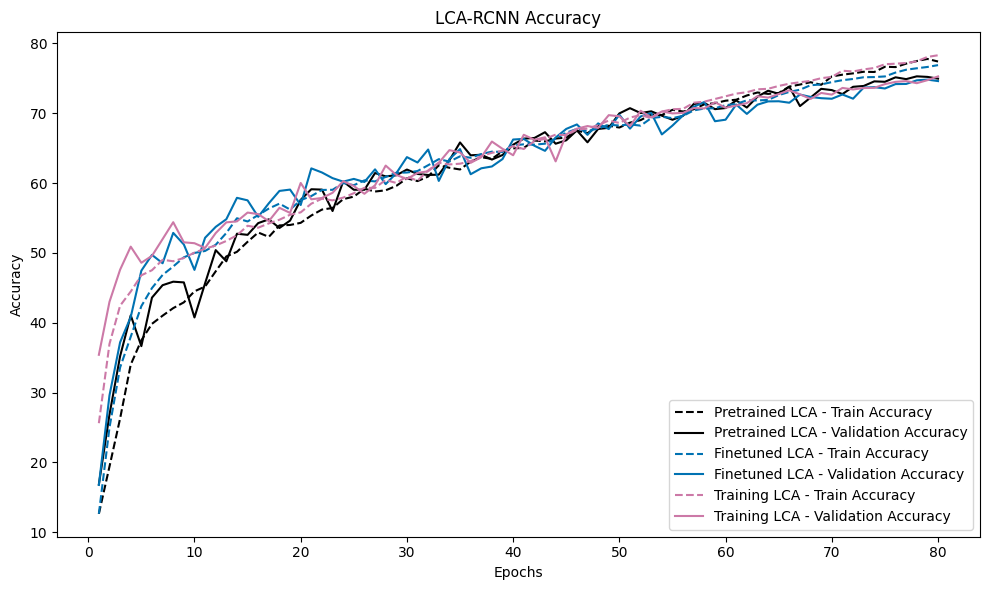

In [21]:
acc_plot = plot_metrics(results_list, key1='Train Accuracy', key2='Validation Accuracy', metric_name='Accuracy', labels=['Pretrained LCA', 'Finetuned LCA', 'Training LCA'])

LCA (pretrained) frontend

/tmp/ipykernel_1550897/3786787210.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model = torch.load(pretrained_path + '/model.pt', map_location=torch.device(

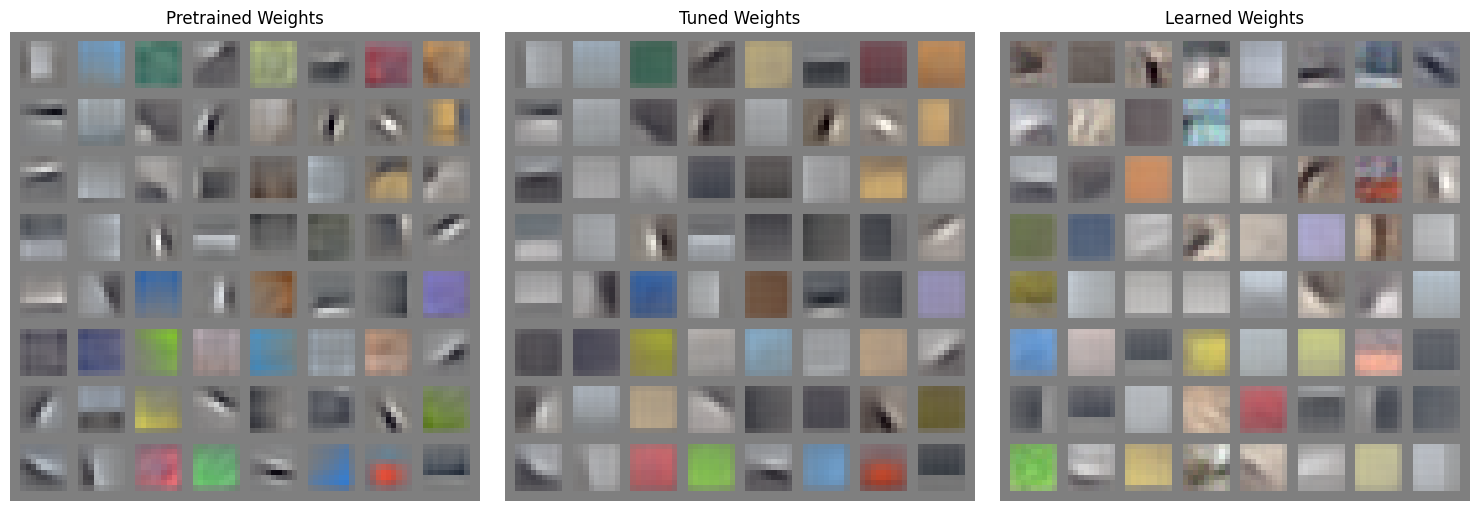

In [22]:
pretrained_model = torch.load(pretrained_path + '/model.pt', map_location=torch.device(pretrained_params['device']))
pretrained_weights = make_feature_grid(pretrained_model.lca.weights)

tuned_model = torch.load(tuned_path + '/model.pt', map_location=torch.device('cpu')).to(tuned_params['device'])
tuned_weights = make_feature_grid(tuned_model.lca.weights)

learndict_model = torch.load(learndict_path + '/model.pt', map_location=torch.device(learndict_params['device']))
learndict_weights = make_feature_grid(learndict_model.lca.weights)

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

axes[0].imshow(pretrained_weights.float().cpu().numpy())
axes[0].set_title("Pretrained Weights")
axes[0].axis("off")

axes[1].imshow(tuned_weights.float().cpu().numpy())
axes[1].set_title("Tuned Weights")
axes[1].axis("off")

axes[2].imshow(learndict_weights.float().cpu().numpy())
axes[2].set_title("Learned Weights")
axes[2].axis("off")
plt.tight_layout()
plt.show()

### Performance Evaluation

In [23]:
transform_test = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=(0.4914, 0.4822, 0.4465),
                std=(3 * 0.2023, 3 * 0.1994, 3 * 0.2010),
            ),
        ]
    )

cifar10_test_dset = torchvision.datasets.CIFAR10("/storage/jr3548@drexel.edu/eplcanet/data/cifar10_pytorch",
        train=False,
        transform=transform_test,
        download=True)

test_loader = torch.utils.data.DataLoader(cifar10_test_dset, batch_size=200, shuffle=False, num_workers=1)

Files already downloaded and verified


In [24]:
print('RCNN with pretrained D')
pretrained_acc, inputs, pretrained_acts = evaluate(pretrained_model, test_loader, pretrained_params['T1'], pretrained_params['device'])
print('RCNN with finetuned D')
tuned_acc, inputs, tuned_acts = evaluate(tuned_model, test_loader, tuned_params['T1'], tuned_params['device'])
print('RCNN while training D')
learndict_acc, inputs, learndict_acts = evaluate(learndict_model, test_loader, learndict_params['T1'], learndict_params['device'])

RCNN with pretrained D
	Test accuracy :	 0.7498
RCNN with finetuned D
	Test accuracy :	 0.7463
RCNN while training D
	Test accuracy :	 0.7528


In [27]:
#Plot reconstruction from each model
pretrained_recon = pretrained_model.lca.compute_recon(pretrained_acts, pretrained_model.lca.weights)
tuned_recon = tuned_model.lca.compute_recon(tuned_acts, tuned_model.lca.weights)
learndict_recon = learndict_model.lca.compute_recon(learndict_acts, learndict_model.lca.weights)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1150327..1.1716803].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.142348..1.2299284].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1603746..1.2874842].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1674564..1.341744].


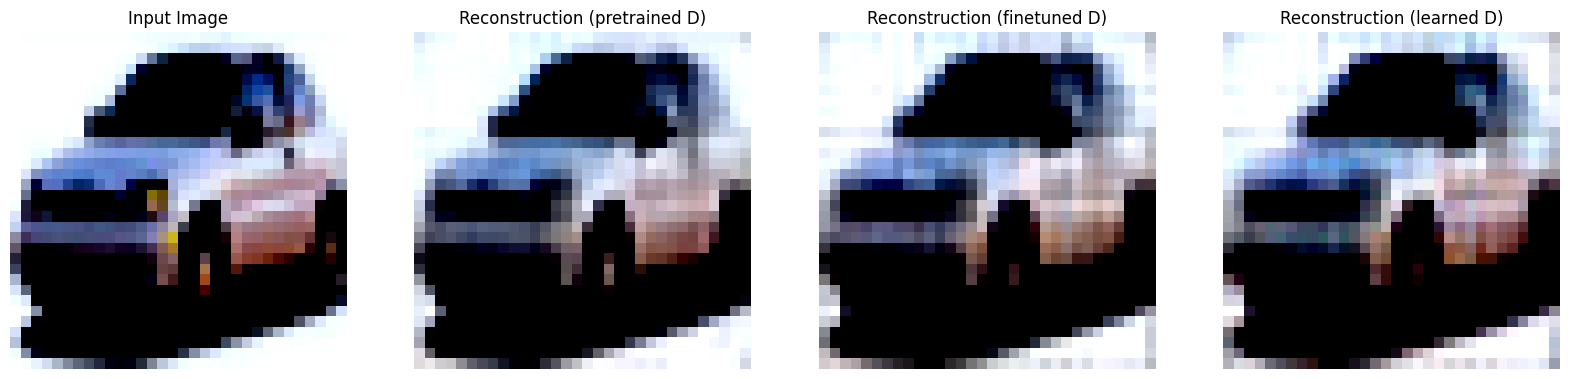

In [28]:
img_idx = 0
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(inputs[img_idx].permute(1, 2, 0).float().cpu().numpy(), cmap="gray")
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(pretrained_recon[img_idx].permute(1, 2, 0).float().cpu().numpy(), cmap="gray")
axes[1].set_title("Reconstruction (pretrained D)")
axes[1].axis("off")

axes[2].imshow(tuned_recon[img_idx].permute(1, 2, 0).float().cpu().numpy(), cmap="gray")
axes[2].set_title("Reconstruction (finetuned D)")
axes[2].axis("off")
axes[3].imshow(learndict_recon[img_idx].permute(1, 2, 0).float().cpu().numpy(), cmap="gray")
axes[3].set_title("Reconstruction (learned D)")
axes[3].axis("off")

plt.show()

In [30]:
learndict_params['epochs']

80

### TODO: Robustness testing

In [31]:
optim_params = []

for idx in range(len(pretrained_model.synapses)):
    if learndict_params['wds'] is None:
        optim_params.append({"params": pretrained_model.synapses[idx].parameters(), "lr": pretrained_params['lrs'][idx]})
    else:
        optim_params.append(
            {
                "params":pretrained_model.synapses[idx].parameters(),
                "lr": pretrained_params['lrs'][idx],
                "weight_decay": pretrained_params['wds'][idx],
            }
        )
    
optimizer = torch.optim.SGD( optim_params, momentum=learndict_params['mmt'] )


In [32]:
print(pretrained_params)

{'model': 'LCACNN', 'task': 'CIFAR10', 'data-aug': None, 'channels': [64, 256, 512], 'kernels': [3, 3, 3], 'pools': 'immmm', 'strides': [1, 1, 1, 1], 'paddings': [1, 1, 1, 1], 'fc': 10, 'optim': 'sgd', 'lrs': [0.25, 0.15, 0.1, 0.08], 'wds': '3e-4', 'mmt': 0.9, 'lr-decay': None, 'epochs': 80, 'act': 'my_hard_sig', 'todo': 'train', 'T1': 500, 'T2': 100, 'mbs': 128, 'alg': 'EP', 'betas': [0.0, 0.5], 'scale': 0.5, 'thirdphase': None, 'loss': 'cel', 'softmax': None, 'save': None, 'device': 3, 'seed': 2, 'lca_feats': 64, 'lca_lambda': 0.25, 'lca_tau': 100, 'lca_eta': 0.05, 'lca_iters': 600, 'lca_stride': 2, 'lca_ksize': 9, 'scale_feedback': 0.01, 'dict_training': 'pretrained'}


In [ ]:
# Adversarial robustness testing for models
def adv_evaluate(model, loader, T, device, epsilon, attack='pgd'):
    model.eval()
    correct, run_total = 0, 0
    phase = 'Test'
    art_model = PyTorchClassifier(model, torch.nn.CrossEntropyLoss(), (3, 32, 32), 10, clip_values=(0, 1))
    art_model.set_params()
    if attack == 'pgd':
        
        attack = ProjectedGradientDescentPyTorch(
            estimator=art_model,
            norm = 2,
            eps=epsilon,
            eps_step=2.5 * epsilon / 20, 
            max_iter=20,
            verbose=False
        )    


    for x, y in loader:
        x, y = x.to(device), y.to(device)
        model.zero_grad() 
        model.eval()
        x_adv = attack.generate(x.cpu().numpy())
        neurons_adv = torch.from_numpy(art_model.predict(x_adv)).to(device)
        #neurons_adv = torch.from_numpy(art_model.predict(x.cpu().numpy(), training_mode = False)).to(device)
        pred_adv = torch.argmax(F.softmax(model.synapses[-1].to(device)(neurons_adv.view(x.size(0),-1)), dim = 1), dim = 1).squeeze()
                
        correct_adv += (y == pred_adv).sum().item()
        
    acc_adv = correct_adv/len(loader.dataset)
    
    print('\tAdversarial test accuracy :\t', acc_adv)
        
    return acc_adv

In [19]:
eps = np.array([0.5,1.0,2.0,3.0,7.0])

In [20]:
pretrained_advacc_eps= []
print('Testing LCA-RCNN with pretrained D on adversarial examples')
for i in eps:
    print('attack epsilon = ', i)
    pretrained_advacc = adv_evaluate(pretrained_model, test_loader, pretrained_params['T2'], pretrained_params['device'], i, attack='pgd')
    pretrained_advacc_eps.append(pretrained_advacc)

Testing LCA-RCNN with pretrained D on adversarial examples
attack epsilon =  0.5


TypeError: one_hot(): argument 'input' (position 1) must be Tensor, not int

In [ ]:
tuned_advacc_eps = []
print('Testing LCA-RCNN with finetuned D on adversarial examples')
for i in eps:
    print('attack epsilon = ', i)
    tuned_advacc = adv_evaluate(tuned_model, test_loader, tuned_params['T1'], tuned_params['device'], i, attack='pgd')
    tuned_advacc_eps.apped(tuned_advacc)

True


In [ ]:
learndict_advacc_eps = []
print('Testing LCA-RCNN with simultaneously trained D on adversarial examples')
for i in eps:
    print('attack epsilon = ', i)
    learndict_advacc = adv_evaluate(learndict_model, test_loader, learndict_params['T1'], learndict_params['device'], i, attack='pgd')
    learndict_advacc_eps.append(learndict_advacc)

More exploratory eval

In [ ]:
path_1 = f'/storage/jr3548@drexel.edu/eplcanet/results/CIFAR10/EP/LCACNN/learn/2024-11-04/run_1'
path_2 = f'/storage/jr3548@drexel.edu/eplcanet/results/CIFAR10/EP/LCACNN/learn/2024-11-07/run_2'

params_1 = read_hyperparameters(pretrained_path + '/hyperparameters.txt')
params_2 = read_hyperparameters(tuned_path + '/hyperparameters.txt')

results_1 = pd.read_csv(f'{rcnn_path}/results.csv', index_col=0)
results_2 = pd.read_csv(f'{pretrained_path}/results.csv', index_col=0)